In [ ]:
!pip install influxdb

     |████████████████████████████████| 77 kB 2.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf


from influxdb import DataFrameClient

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dbhost = '34.77.9.141'
dbport = 8086
dbuser = 'root'
dbpasswd = '12345678'
dbname = 'registros_contaminacion'

client = DataFrameClient(dbhost, dbport, dbuser, dbpasswd, dbname)

df = client.query('select * from ESTACION_8')['ESTACION_8']

In [ ]:
df = df[["NO2", "SO2", "PM10", "PM25", "O3"]] # Categoria
df

,NO2,SO2,PM10,PM25,O3
2001-01-01 00:00:00+00:00,67.0,26.0,32.0,NaN,7.0
2001-01-01 01:00:00+00:00,71.0,21.0,41.0,NaN,7.0
2001-01-01 02:00:00+00:00,73.0,22.0,50.0,NaN,7.0
2001-01-01 03:00:00+00:00,75.0,19.0,55.0,NaN,7.0
2001-01-01 04:00:00+00:00,67.0,14.0,42.0,NaN,8.0
...,...,...,...,...,...
2022-04-18 12:00:00+00:00,29.0,4.0,19.0,8.0,70.0
2022-04-18 13:00:00+00:00,NaN,NaN,15.0,4.0,NaN
2022-04-18 14:00:00+00:00,NaN,NaN,10.0,4.0,NaN
2022-04-18 15:00:00+00:00,22.0,4.0,10.0,4.0,100.0


In [ ]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled

  
#df = clean_data(df)
df = df.dropna() # drop NaN

df_features = df.copy()

df_features['Hour'] = df.index.hour
df_features['Day'] = df.index.day
df_features['Month_Of_Year'] = df.index.month
df_features['Year'] = df.index.year

df_features

,NO2,SO2,PM10,PM25,O3,Hour,Day,Month_Of_Year,Year
2009-12-30 08:00:00+00:00,40.0,8.0,22.0,7.0,27.0,8,30,12,2009
2009-12-30 09:00:00+00:00,52.0,10.0,35.0,14.0,24.0,9,30,12,2009
2009-12-30 10:00:00+00:00,50.0,10.0,19.0,12.0,28.0,10,30,12,2009
2009-12-30 11:00:00+00:00,45.0,10.0,22.0,8.0,38.0,11,30,12,2009
2009-12-30 12:00:00+00:00,38.0,10.0,5.0,1.0,49.0,12,30,12,2009
...,...,...,...,...,...,...,...,...,...
2022-04-18 10:00:00+00:00,31.0,4.0,14.0,9.0,58.0,10,18,4,2022
2022-04-18 11:00:00+00:00,31.0,4.0,12.0,6.0,62.0,11,18,4,2022
2022-04-18 12:00:00+00:00,29.0,4.0,19.0,8.0,70.0,12,18,4,2022
2022-04-18 15:00:00+00:00,22.0,4.0,10.0,4.0,100.0,15,18,4,2022


In [ ]:
df_aux = df_features.copy()

validate = df_aux[['NO2', 'SO2', 'PM10', 'PM25', 'O3', 'Hour', 'Day', 'Month_Of_Year', 'Year']].tail(10)
validate

df_features.drop(df_features.tail(10).index,inplace=True)

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [ ]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(df_features[['NO2', 'SO2', 'PM10', 'PM25', 'O3', 'Hour', 'Day', 'Month_Of_Year', 'Year']])
Y_data = Y_scaler.fit_transform(df_features[['NO2']])

In [ ]:
hist_window = 24
horizon = 10
TRAIN_SPLIT = 80000 #30000 
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
x_train

array([[[0.09863014, 0.11864407, 0.05737705, ..., 0.96666667,
         1.        , 0.        ],
        [0.13150685, 0.15254237, 0.09289617, ..., 0.96666667,
         1.        , 0.        ],
        [0.1260274 , 0.15254237, 0.04918033, ..., 0.96666667,
         1.        , 0.        ],
        ...,
        [0.06849315, 0.11864407, 0.01092896, ..., 1.        ,
         1.        , 0.        ],
        [0.08219178, 0.13559322, 0.02459016, ..., 1.        ,
         1.        , 0.        ],
        [0.09041096, 0.13559322, 0.03551913, ..., 1.        ,
         1.        , 0.        ]],

       [[0.13150685, 0.15254237, 0.09289617, ..., 0.96666667,
         1.        , 0.        ],
        [0.1260274 , 0.15254237, 0.04918033, ..., 0.96666667,
         1.        , 0.        ],
        [0.11232877, 0.15254237, 0.05737705, ..., 0.96666667,
         1.        , 0.        ],
        ...,
        [0.08219178, 0.13559322, 0.02459016, ..., 1.        ,
         1.        , 0.        ],
        [0.0

In [ ]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[0.09863014 0.11864407 0.05737705 0.03255814 0.13567839 0.34782609
  0.96666667 1.         0.        ]
 [0.13150685 0.15254237 0.09289617 0.06511628 0.12060302 0.39130435
  0.96666667 1.         0.        ]
 [0.1260274  0.15254237 0.04918033 0.05581395 0.14070352 0.43478261
  0.96666667 1.         0.        ]
 [0.11232877 0.15254237 0.05737705 0.0372093  0.19095477 0.47826087
  0.96666667 1.         0.        ]
 [0.09315068 0.15254237 0.01092896 0.00465116 0.24623116 0.52173913
  0.96666667 1.         0.        ]
 [0.10136986 0.15254237 0.05464481 0.05116279 0.24120603 0.56521739
  0.96666667 1.         0.        ]
 [0.11232877 0.15254237 0.05737705 0.04651163 0.21105528 0.60869565
  0.96666667 1.         0.        ]
 [0.08493151 0.13559322 0.02185792 0.01860465 0.25125628 0.65217391
  0.96666667 1.         0.        ]
 [0.08493151 0.13559322 0.09836066 0.04186047 0.23115578 0.69565217
  0.96666667 1.         0.        ]
 [0.11780822 0.15254237 0.01092

In [ ]:
batch_size = 256
buffer_size = 150

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [ ]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')


In [ ]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 24, 400)          336000    
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 24, 20)            8020      
                                                                 
 bidirectional_11 (Bidirecti  (None, 300)              205200    
 onal)                                                           
                                                                 
 dense_21 (Dense)            (None, 20)                6020      
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dropout_5 (Dropout)         (None, 20)               

In [ ]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

In [ ]:
history = lstm_model.fit(train_data,epochs=150,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/150
100/100 [==============================] - 15s 76ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 2/150
100/100 [==============================] - 6s 57ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 3/150
100/100 [==============================] - 6s 57ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 4/150
100/100 [==============================] - 6s 58ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 5/150
100/100 [==============================] - 6s 58ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 6/150
100/100 [==============================] - 6s 57ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 7/150
100/100 [==============================] - 6s 56ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 8/150
100/100 [==============================] - 6s 56ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 9/150
100/100 [==============================] - 6s 59ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 10/150
100/100 [==============================] - 6s 56ms/step - loss: 0.00

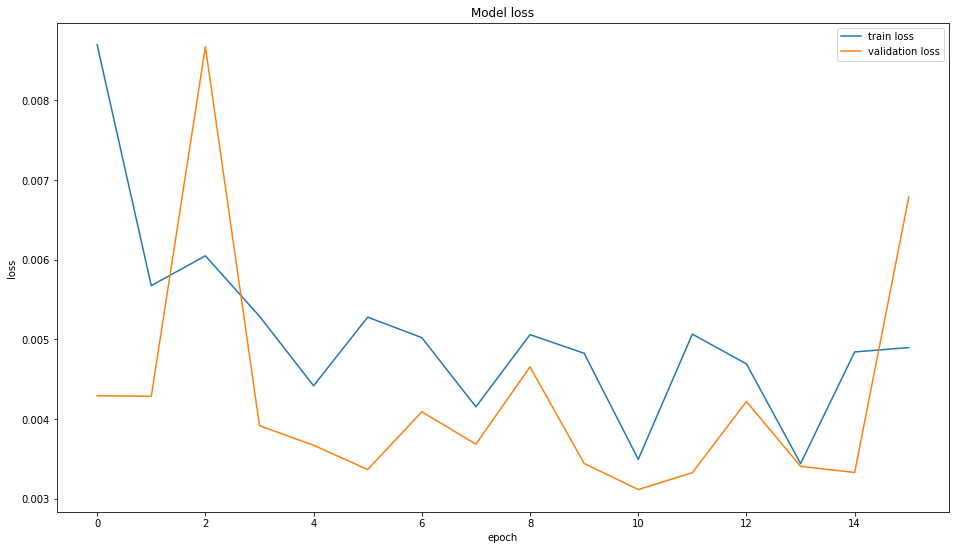

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
data.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'traffic_volume'],
      dtype='object')

In [ ]:
data_val = X_scaler.fit_transform(df_features[['NO2', 'SO2', 'PM10', 'PM25', 'O3', 'Hour', 'Day', 'Month_Of_Year', 'Year']].tail(24)) # tail del tamaño del input
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [ ]:
pred = lstm_model.predict(val_rescaled)
pred

array([[0.1478043 , 0.1828264 , 0.18291438, 0.19104329, 0.20869508,
        0.2010971 , 0.21232143, 0.25626642, 0.28834298, 0.307441  ]],
      dtype=float32)

In [ ]:
pred_Inverse = Y_scaler.inverse_transform(pred)

In [ ]:
pred_Inverse

array([[ 57.948574,  70.731636,  70.76375 ,  73.730804,  80.173706,
         77.400444,  81.49732 ,  97.53725 , 109.24519 , 116.215965]],
      dtype=float32)

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
pred_Inverse[0]

array([ 57.948574,  70.731636,  70.76375 ,  73.730804,  80.173706,
        77.400444,  81.49732 ,  97.53725 , 109.24519 , 116.215965],
      dtype=float32)

In [ ]:
timeseries_evaluation_metrics_func(validate['NO2'],pred_Inverse[0])

Evaluation metric results:-
MSE is : 3467.4122959819406
MAE is : 55.22446403503418
RMSE is : 58.88473737720107
MAPE is : 226.7248804216117
R2 is : -42.774931144829445



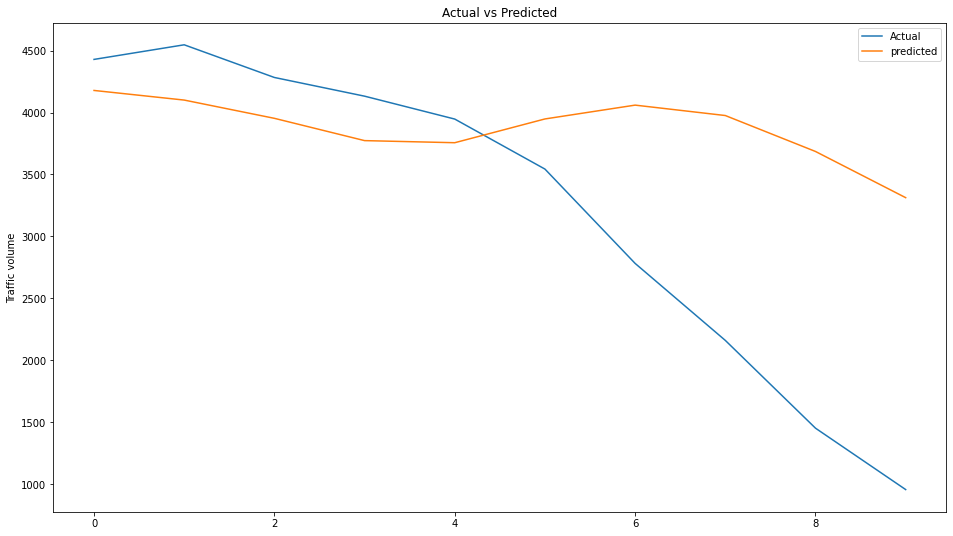

In [ ]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['traffic_volume']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()